In [32]:
subj = "Subj1"
exp = "exp_sep2"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = (exp != "reproduction")
scale = False

### Imports

In [33]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [34]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
features = df_features.to_numpy()
print('Features: ', features.shape)

Opening raw data file Subj1/src/data_rr_filt-raw.fif...
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
Features:  (1046, 64)


In [35]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    if exp != "reproduction": features = features[:-2]

### SDA

In [36]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1046 samples with 64 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [37]:
if exp != "reproduction":
    edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
    print(edges_true)

    metrics = [ ]
    for row in  tqdm.tqdm(result['St_edges']):
        metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
    result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0   39  282  492  560  682  784  857  976 1046]


100%|██████████| 2016/2016 [00:06<00:00, 311.16it/s]


In [38]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [39]:
def analyze(result: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_stats(features, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/stats.svg")
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")

#### Internal

St_len_min  K_nb_max  N_cl_max  N_stages  Cl_cen  \
0            0        40        15         3    Mode   
1            0        40        10         4  Median   
2           60        35        15         5  Median   
3           60        40        15         6  Median   
4           20        35        20         7    Mode   
5           20        35        20         8    Mode   
6           20        35        20         9    Mode   
7           40        40        20        10    Mode   
8           20        35        20        11    Mode   
9           20        35        20        12    Mode   
10          40        40        20        13    Mode   
11          40        45        10        14  Median   
12          60        50        10        15  Median   
13          40        45        20        16    Mode   

                                             St_edges  Ward_dist  Cen_dist  \
0                                 [0, 479, 682, 1046]  137682.17     31.00   
1                            [0, 203, 555, 931, 1046]   63926.68     20.16   
2                       [0, 203, 554, 682, 888, 1046]  116959.34     34.09   
3                   [0, 92, 232, 554, 682, 888, 1046]   89960.30     31.51   
4             [0, 136, 203, 554, 682, 842, 976, 1046]  103760.40     38.66   
5        [0, 136, 203, 342, 554, 682, 842, 976, 1046]   82382.32     34.24   
6   [0, 136, 203, 342, 479, 554, 682, 842, 976, 1046]   65794.60     31.83   
7   [0, 91, 203, 342, 479, 554, 682, 785, 842, 976...   53378.61     31.39   
8   [0, 44, 136, 203, 342, 479, 554, 682, 842, 931...   50744.13     30.99   
9   [0, 44, 136, 203, 342, 479, 554, 682, 785, 842...   43656.65     30.96   
10  [0, 91, 136, 203, 261, 342, 479, 554, 682, 785...   39492.77     29.99   
11  [0, 52, 91, 186, 203, 246, 294, 340, 479, 554,...   38605.02     29.92   
12  [0, 91, 128, 186, 203, 246, 295, 340, 444, 479...   32252.07     28.20   
13  [0, 44, 91, 136, 186, 203, 246, 280, 342, 479,...   31995.03     29.14   

        Silh  Cal-Har  Dav-Bold  Avg-Silh  Avg-Cal-Har  Avg-Dav-Bold   AMI  \
0   2.33e-02    35.99      5.32      0.06        44.25          3.64  0.64   
1   1.69e-02    26.71      7.47      0.04        21.54          6.49  0.63   
2   1.88e-02    33.07      6.17      0.08        39.00          3.43  0.73   
3  -3.29e-03    28.97      5.94      0.07        30.01          3.61  0.74   
4   8.69e-03    31.15      5.54      0.10        34.54          2.79  0.77   
5   4.28e-03    28.20      5.52      0.08        27.44          3.37  0.78   
6  -5.19e-03    25.69      5.41      0.07        22.05          3.60  0.80   
7  -7.53e-03    24.13      5.34      0.07        18.18          3.63  0.83   
8  -1.60e-02    22.22      5.17      0.07        17.16          3.69  0.80   
9  -1.38e-02    21.33      5.08      0.07        15.00          3.67  0.82   
10 -1.39e-02    19.92      5.30      0.06        13.51          3.85  0.81   
11 -3.62e-02    17.95      5.16      0.07        13.14          3.77  0.79   
12 -2.47e-02    16.67      5.61      0.06        11.03          4.10  0.78   
13 -2.92e-02    16.71      5.16      0.07        11.15          3.88  0.81   

     ARI   FMI  
0   0.43  0.61  
1   0.41  0.56  
2   0.54  0.64  
3   0.56  0.64  
4   0.56  0.64  
5   0.58  0.64  
6   0.61  0.66  
7   0.66  0.71  
8   0.59  0.65  
9   0.63  0.69  
10  0.60  0.67  
11  0.58  0.65  
12  0.57  0.64  
13  0.61  0.68

St_len_min  K_nb_max  N_cl_max  N_stages Cl_cen  \
0          20        35        20         9   Mode   

                                            St_edges  Ward_dist  Cen_dist  \
0  [0, 136, 203, 342, 479, 554, 682, 842, 976, 1046]    65794.6     31.83   

       Silh  Cal-Har  Dav-Bold  Avg-Silh  Avg-Cal-Har  Avg-Dav-Bold  AMI  \
0 -5.19e-03    25.69      5.41      0.07        22.05           3.6  0.8   

    ARI   FMI  
0  0.61  0.66

array([   0,  136,  203,  342,  479,  554,  682,  842,  976, 1046])

Silh  Cal-Har  Dav-Bold       Ward  Centr
0  0.08    15.56      3.35   36640.87  28.57
1  0.05    10.93      3.95   29240.39  25.43
2  0.03     8.52      5.53   25029.41  19.05
3  0.01     6.85      5.07   20174.43  20.40
4  0.06    17.02      3.20   46209.03  31.26
5  0.15    59.13      2.12  175218.94  49.64
6  0.10    37.98      2.69  123360.62  41.13
7  0.08    20.45      2.87   70483.13  39.15

0               1               2  \
Start-end time, sec  (9.9, 129.1)  (129.9, 193.1)  (193.9, 319.5)   
Time length, sec            119.2            63.2           125.6   
Number of epochs              136              67             139   

                                  3               4               5  \
Start-end time, sec  (320.3, 444.3)  (445.1, 506.7)  (507.5, 620.3)   
Time length, sec              124.0            61.6           112.8   
Number of epochs                137              75             128   

                                  6               7               8  
Start-end time, sec  (621.1, 758.7)  (759.5, 877.1)  (877.9, 938.7)  
Time length, sec              137.6           117.6            60.8  
Number of epochs                160             134              70

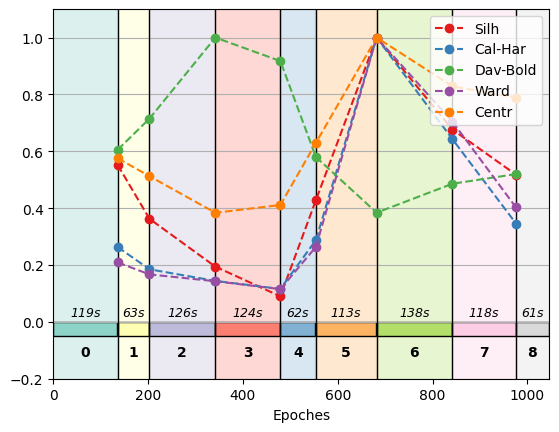

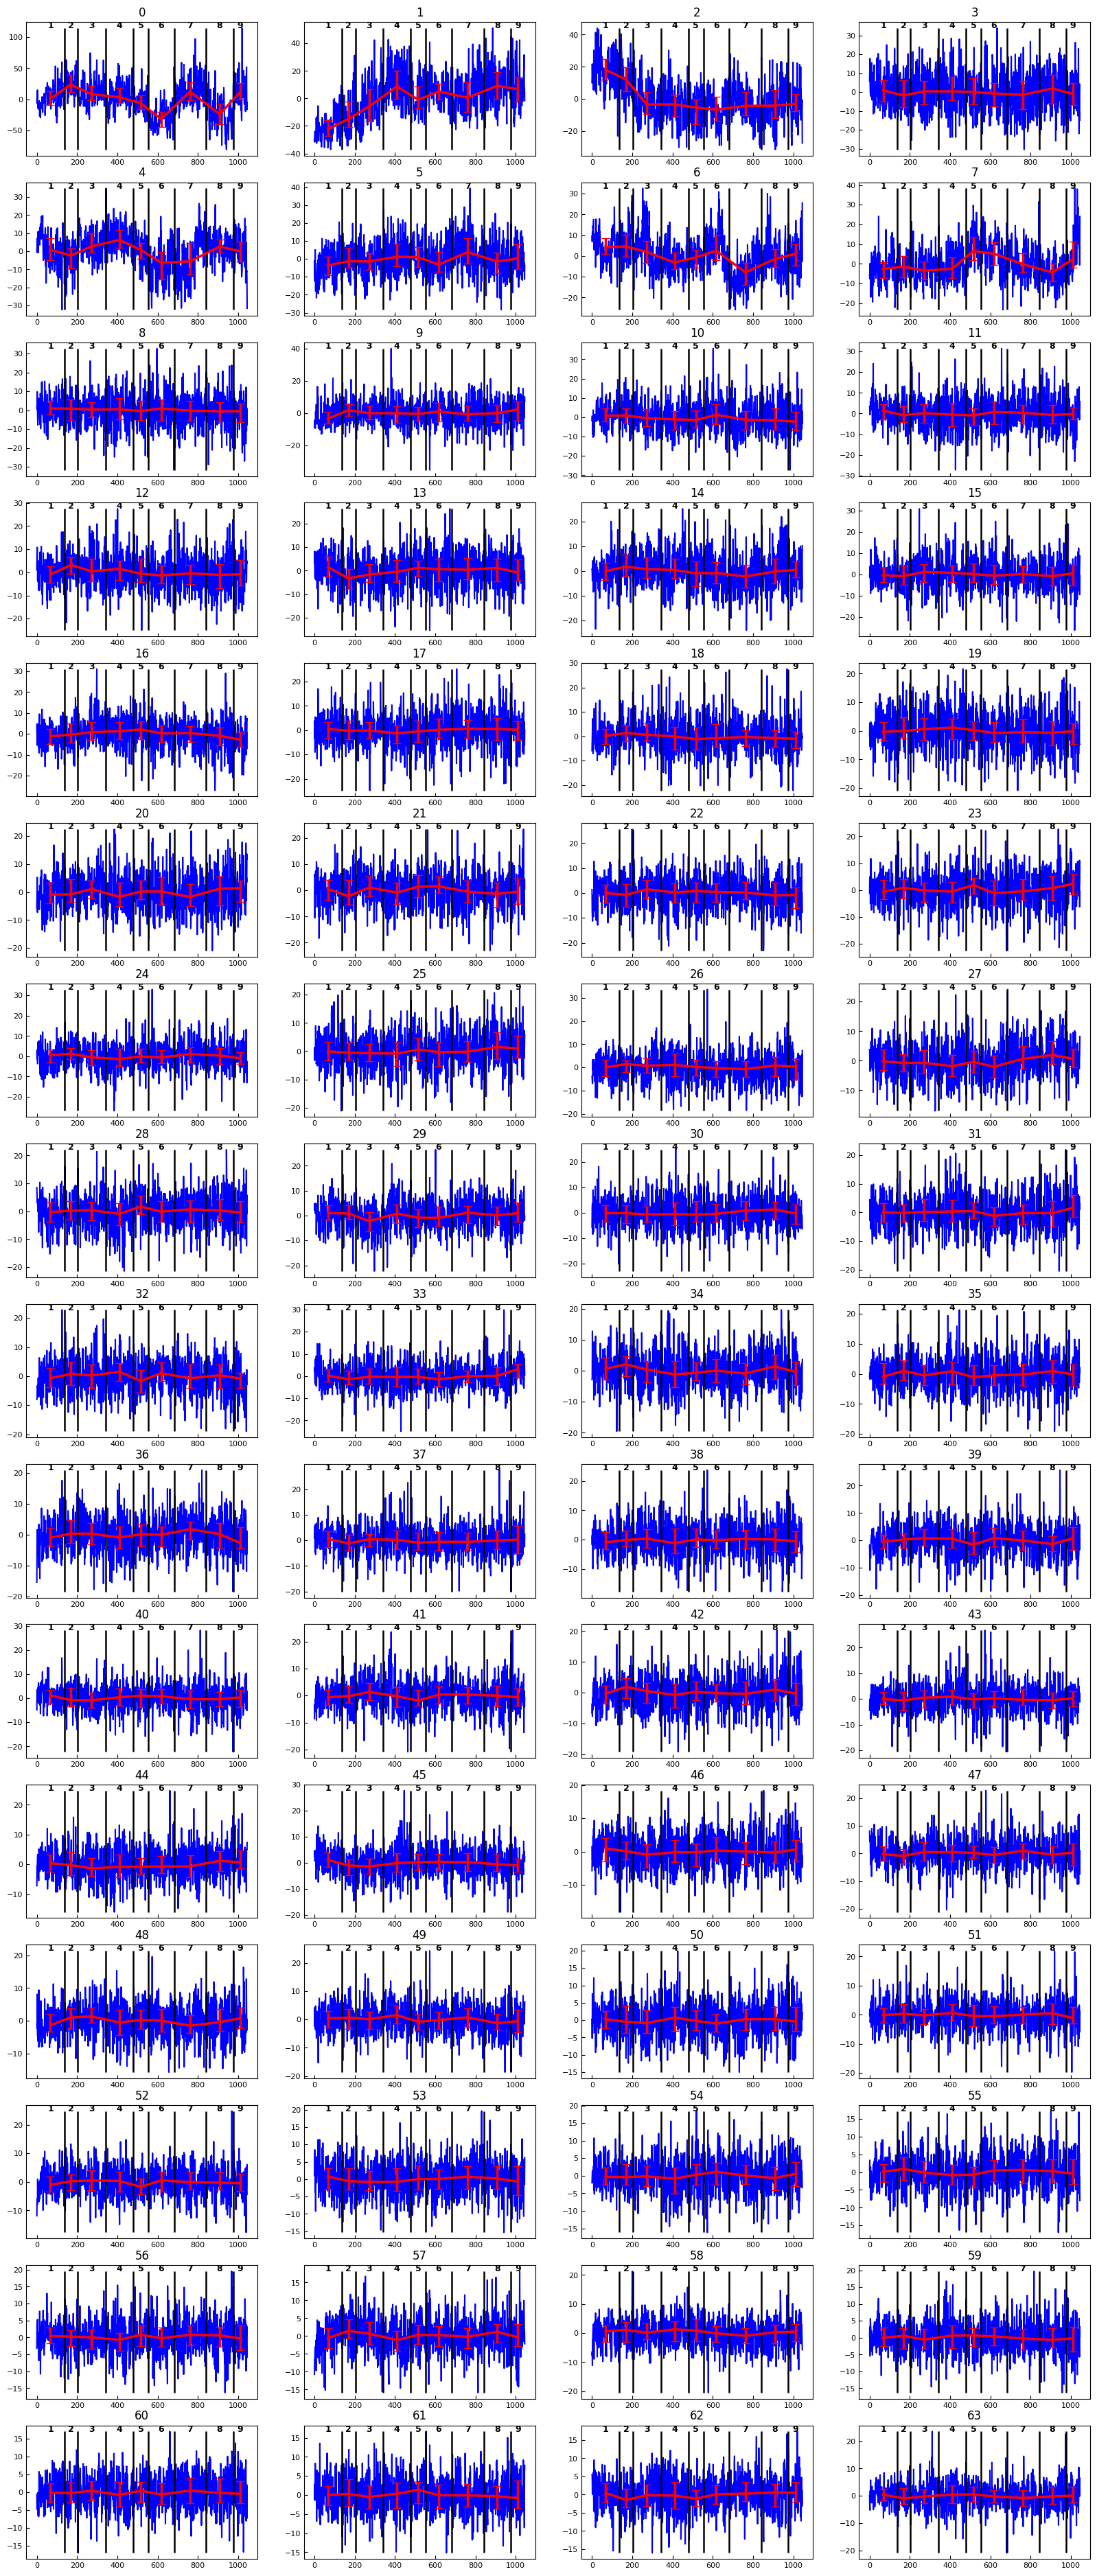

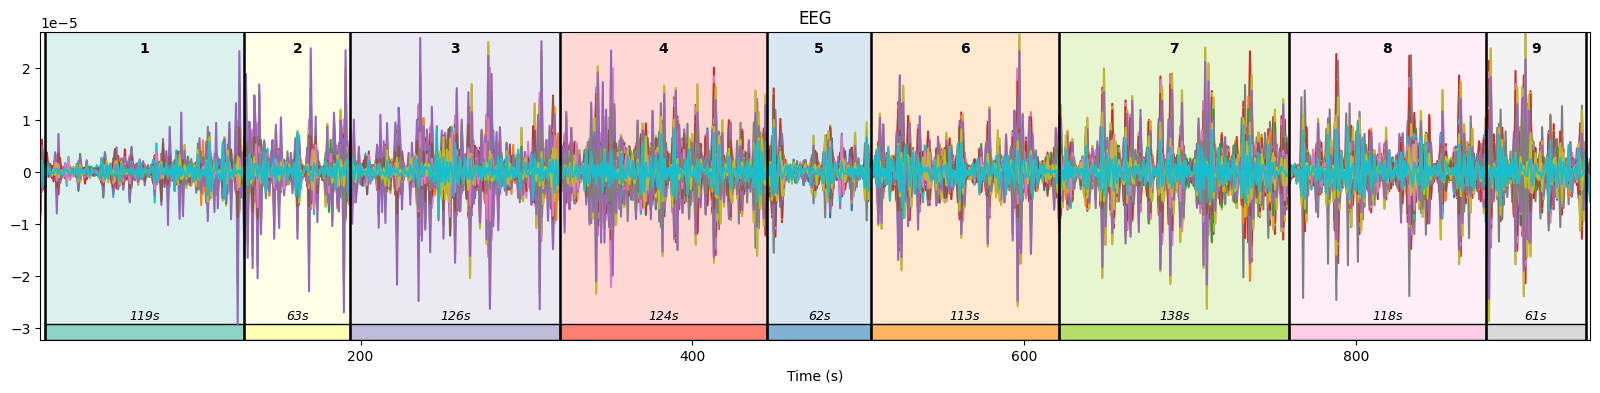

In [40]:
analyze(result, 'Avg-Silh', "internal")
# [   0   39  282  492  560  682  784  857  976 1046]
# array([   0,   46,  210,  340,  554,  682,  784,  846,  975, 1046])

![Alternative Text][1707850881559]

[1707850881559]: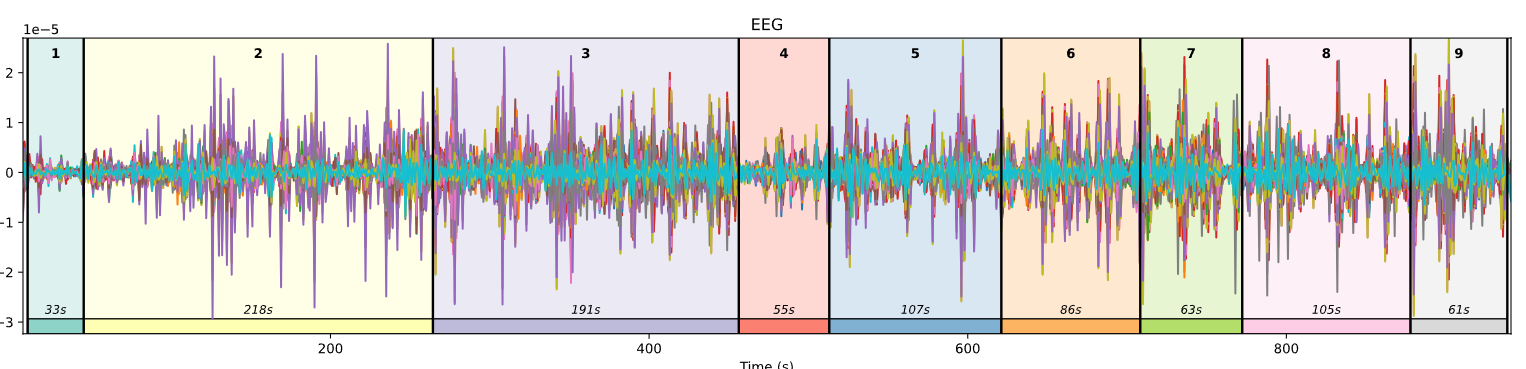

#### External

St_len_min  K_nb_max  N_cl_max  N_stages  Cl_cen  \
0            0        40        15         3    Mode   
1           60        40        20         4  Median   
2            0        40        20         5    Mode   
3           60        50        20         6    Mode   
4           60        50        20         7    Mode   
5           20        45        20         8    Mode   
6           20        45        20         9    Mode   
7           20        45        20        10    Mode   
8            0        50        20        11    Mode   
9            0        50        20        12    Mode   
10           0        50        20        13    Mode   
11           0        45        15        14    Mode   
12           0        50        15        15    Mode   
13           0        50        15        16    Mode   

                                             St_edges  Ward_dist  Cen_dist  \
0                                 [0, 479, 682, 1046]  137682.17     31.00   
1                            [0, 203, 556, 855, 1046]   63676.75     20.55   
2                       [0, 238, 479, 682, 976, 1046]   81908.72     27.07   
3                   [0, 91, 295, 556, 682, 976, 1046]   76008.69     29.21   
4              [0, 91, 295, 556, 682, 842, 976, 1046]  104483.54     37.04   
5         [0, 44, 203, 280, 479, 682, 842, 976, 1046]   77240.16     32.87   
6    [0, 44, 203, 280, 479, 554, 682, 842, 976, 1046]   65604.33     32.17   
7   [0, 44, 203, 280, 479, 554, 682, 785, 842, 976...   52735.15     32.11   
8   [0, 91, 238, 280, 479, 556, 682, 785, 842, 976...   45741.40     32.01   
9   [0, 44, 91, 238, 280, 479, 556, 682, 785, 842,...   40930.42     30.80   
10  [0, 44, 91, 186, 238, 295, 479, 556, 682, 785,...   37528.32     29.02   
11  [0, 44, 92, 186, 238, 280, 328, 479, 554, 682,...   34925.94     28.39   
12  [0, 44, 91, 186, 238, 295, 328, 479, 554, 682,...   30148.41     27.63   
13  [0, 44, 91, 136, 186, 238, 295, 328, 479, 554,...   28352.85     27.03   

        Silh  Cal-Har  Dav-Bold  Avg-Silh  Avg-Cal-Har  Avg-Dav-Bold   AMI  \
0   2.33e-02    35.99      5.32      0.06        44.25          3.64  0.64   
1   1.65e-02    27.83      6.64      0.04        21.37          6.07  0.69   
2   1.96e-02    29.56      6.02      0.05        26.97          4.21  0.76   
3  -5.58e-03    27.56      6.08      0.05        25.06          3.83  0.80   
4   2.07e-03    30.86      5.73      0.08        34.58          3.00  0.84   
5  -8.22e-03    26.50      5.83      0.06        25.57          3.32  0.85   
6  -1.34e-02    25.51      5.46      0.06        22.02          3.47  0.88   
7  -1.24e-02    24.01      5.35      0.06        18.01          3.47  0.90   
8  -2.16e-02    21.45      5.31      0.05        15.46          3.55  0.88   
9  -3.70e-02    19.97      5.23      0.05        13.95          3.61  0.89   
10 -3.58e-02    18.72      5.49      0.05        12.81          3.99  0.86   
11 -3.78e-02    17.59      5.41      0.04        11.94          4.03  0.85   
12 -3.90e-02    16.65      5.55      0.04        10.44          4.14  0.83   
13 -3.93e-02    15.75      5.57      0.04         9.83          4.22  0.82   

     ARI   FMI  
0   0.43  0.61  
1   0.49  0.61  
2   0.60  0.69  
3   0.63  0.70  
4   0.73  0.77  
5   0.73  0.77  
6   0.79  0.82  
7   0.83  0.85  
8   0.79  0.82  
9   0.80  0.83  
10  0.73  0.77  
11  0.68  0.74  
12  0.66  0.72  
13  0.63  0.70

St_len_min  K_nb_max  N_cl_max  N_stages Cl_cen  \
0          20        45        20         9   Mode   

                                           St_edges  Ward_dist  Cen_dist  \
0  [0, 44, 203, 280, 479, 554, 682, 842, 976, 1046]   65604.33     32.17   

   Silh  Cal-Har  Dav-Bold  Avg-Silh  Avg-Cal-Har  Avg-Dav-Bold   AMI   ARI  \
0 -0.01    25.51      5.46      0.06        22.02          3.47  0.88  0.79   

    FMI  
0  0.82

array([   0,   44,  203,  280,  479,  554,  682,  842,  976, 1046])

Silh  Cal-Har  Dav-Bold       Ward  Centr
0  3.95e-02    14.23      2.85   33720.91  31.28
1  4.84e-02    11.19      4.16   28402.42  23.40
2  1.27e-02     8.29      4.90   24395.32  20.96
3  7.53e-03     7.86      4.99   23044.23  20.57
4  6.27e-02    17.02      3.20   46209.03  31.26
5  1.46e-01    59.13      2.12  175218.94  49.64
6  9.90e-02    37.98      2.69  123360.62  41.13
7  7.57e-02    20.45      2.87   70483.13  39.15

0              1               2  \
Start-end time, sec  (9.9, 48.3)  (49.1, 193.1)  (193.9, 261.9)   
Time length, sec            38.4          144.0            68.0   
Number of epochs              44            159              77   

                                  3               4               5  \
Start-end time, sec  (262.7, 444.3)  (445.1, 506.7)  (507.5, 620.3)   
Time length, sec              181.6            61.6           112.8   
Number of epochs                199              75             128   

                                  6               7               8  
Start-end time, sec  (621.1, 758.7)  (759.5, 877.1)  (877.9, 938.7)  
Time length, sec              137.6           117.6            60.8  
Number of epochs                160             134              70

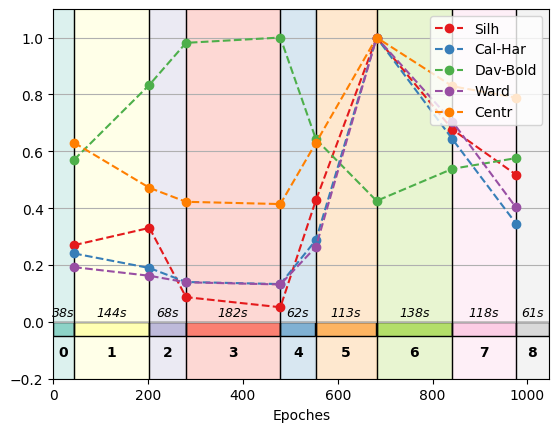

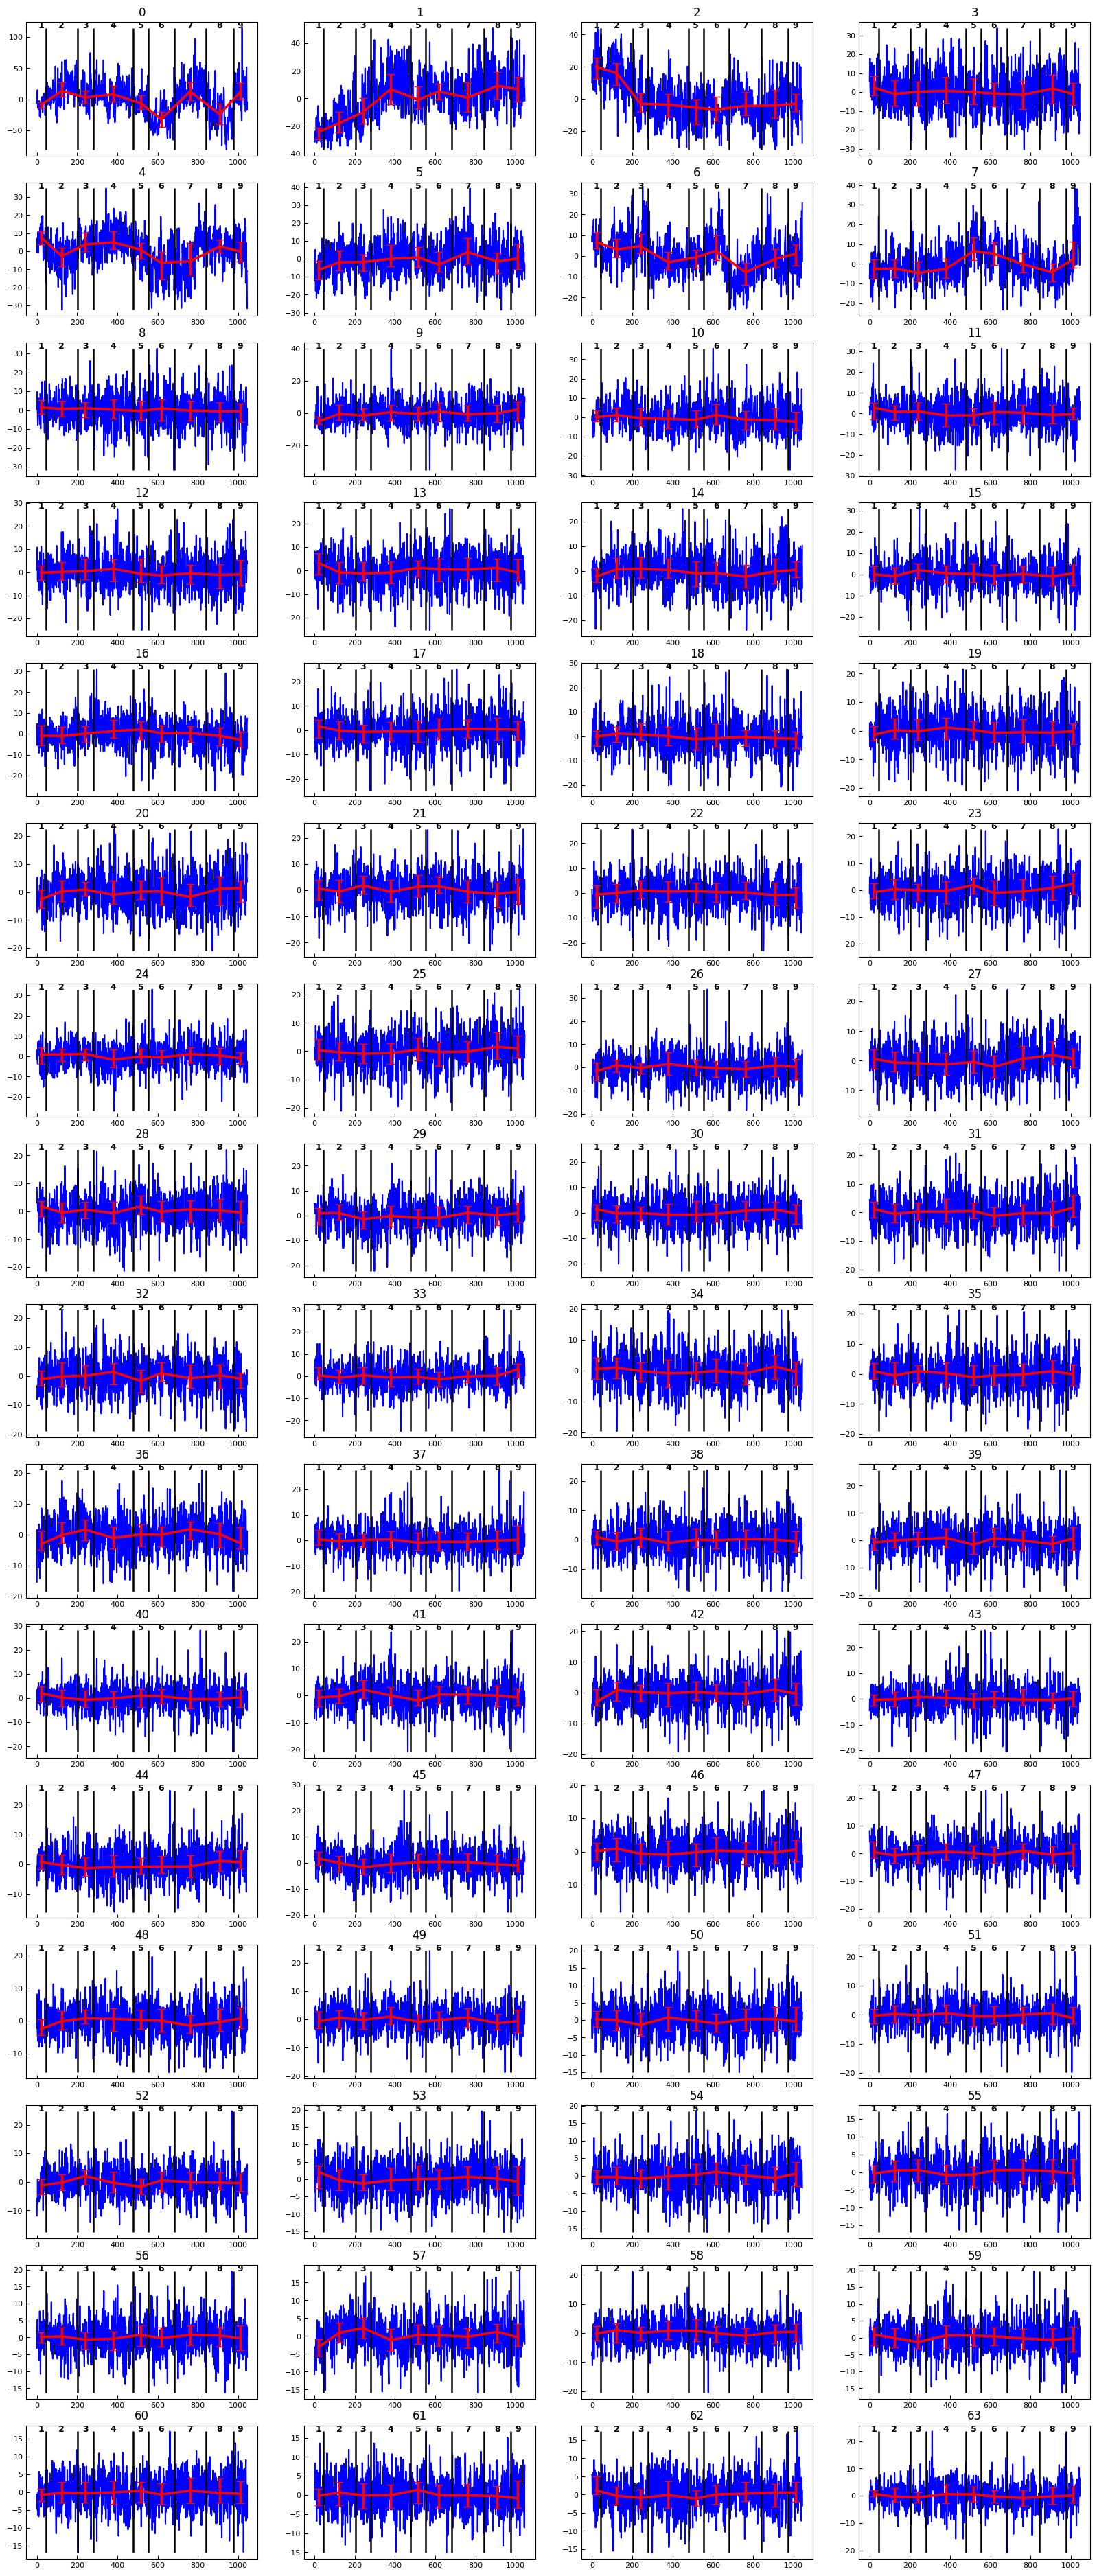

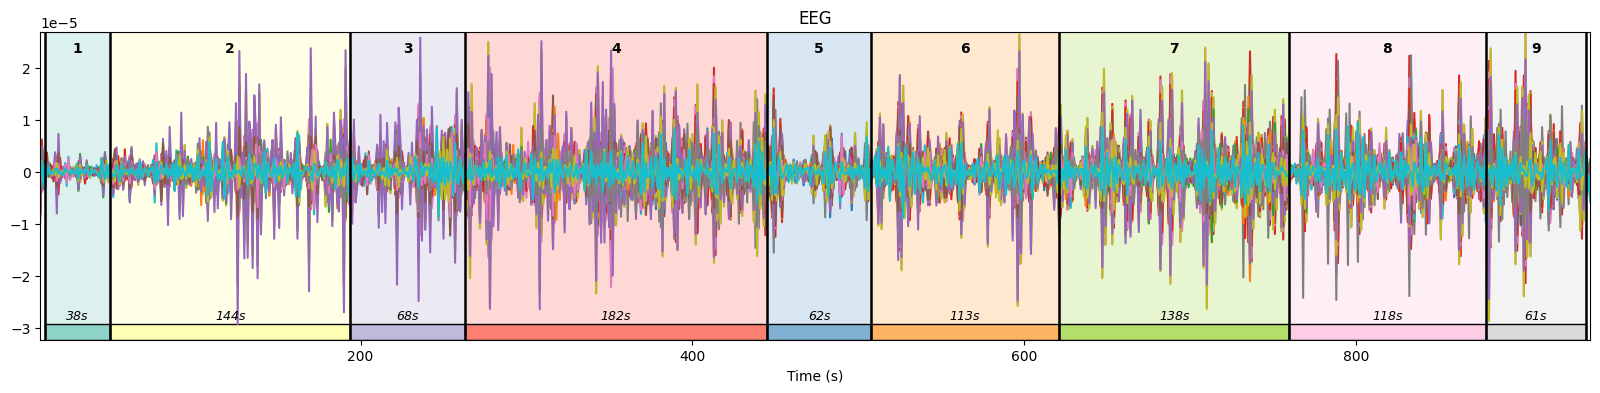

In [41]:
if exp != "reproduction":
    analyze(result, 'FMI', "external")
# [   0   39  282  492  560  682  784  857  976 1046]

![Alternative Text][1707850881559]

[1707850881559]: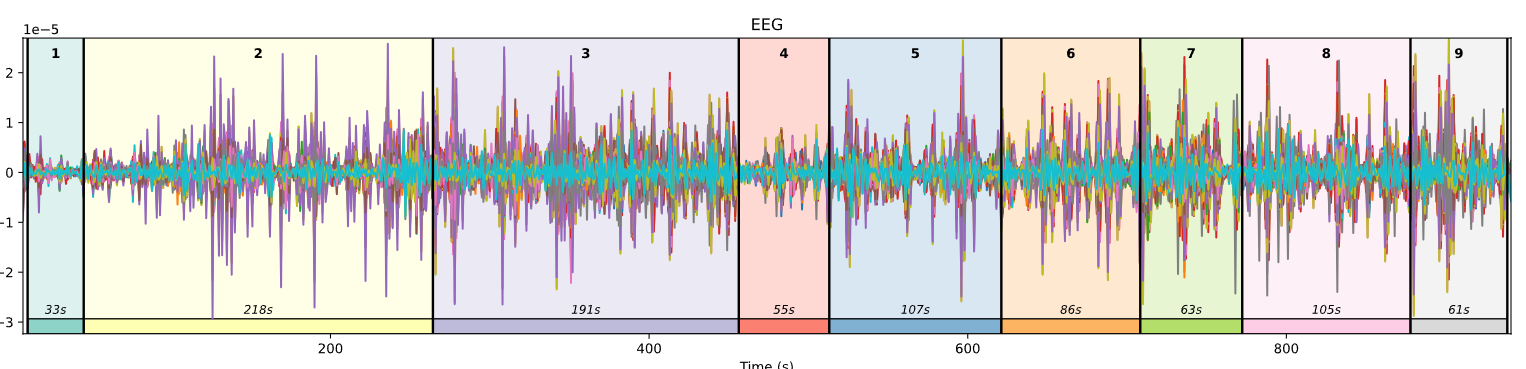